In [1]:
import pandas as pd
df = pd.read_parquet('https://huggingface.co/datasets/scikit-learn/churn-prediction/resolve/refs%2Fconvert%2Fparquet/default/train/0000.parquet', engine='pyarrow')

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def train_logistic_regression(X, y):
  # Define categorical columns
  categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
  numeric_features = [col for col in X.columns if X[col].dtype in ["float64", "int64"]]

  # Create a pipeline for preprocessing categorical variables
  categorical_transformer = Pipeline(steps=[
      ('onehot', OneHotEncoder(handle_unknown='ignore'))
  ])

  numeric_transformer = Pipeline(
      steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
  )

  # Combine preprocessing steps with ColumnTransformer
  preprocessor = ColumnTransformer(
      transformers=[
          ("num", numeric_transformer, numeric_features),
          ('cat', categorical_transformer, categorical_cols)
  ])

  # Append classifier to preprocessing pipeline
  # Now we have a full prediction pipeline
  clf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression())])

  # Fit the model
  clf.fit(X, y)

  # Get the feature names
  feature_names = clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out() #(input_features=categorical_cols)

  # Get the coefficients
  coefficients = clf.named_steps['classifier'].coef_

  nested_dict = { }
  i = 0

  # Match coefficient to column values
  for column in (numeric_features + categorical_cols):
    if column in categorical_cols:
      sub_dict = { }
      for feature_name in feature_names:
        if feature_name.startswith(column):
          name = feature_name.replace(column + "_","")
          sub_dict[name] = coefficients[:,i].item()
          i+=1
      nested_dict[column] = sub_dict
    else:
      nested_dict[column] = coefficients[:,i].item()
      i+=1

  return clf, nested_dict

def train_decision_tree(X, y):
  # Define categorical columns
  categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
  numeric_features = [col for col in X.columns if X[col].dtype in ["float64", "int64"]]

  # Create a pipeline for preprocessing categorical variables
  categorical_transformer = Pipeline(steps=[
      ('onehot', OneHotEncoder(handle_unknown='ignore'))
  ])

  numeric_transformer = Pipeline(
      steps=[("imputer", SimpleImputer(strategy="median"))]
  )

  # Combine preprocessing steps with ColumnTransformer
  preprocessor = ColumnTransformer(
      transformers=[
          ("num", numeric_transformer, numeric_features),
          ('cat', categorical_transformer, categorical_cols)
  ])

  # Append classifier to preprocessing pipeline
  # Now we have a full prediction pipeline
  clf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', DecisionTreeClassifier(min_samples_leaf=1000))])

  # Fit the model
  clf.fit(X, y)

  # Get the feature names
  feature_names = clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out() #(input_features=categorical_cols)

  full_list = numeric_features
  full_list.extend(feature_names)

  return clf, full_list

In [3]:
outcome = (df["Churn"]=="Yes")
inputFeatures = df[["MonthlyCharges", "PaperlessBilling", "Contract"]]

lr_model, coefficients_dict = train_logistic_regression(inputFeatures, outcome)
import json
print(json.dumps(coefficients_dict, indent=2))

{
  "MonthlyCharges": 0.4845543473061657,
  "PaperlessBilling": {
    "No": -0.7825338143932292,
    "Yes": -0.340902062351931
  },
  "Contract": {
    "Month-to-month": 1.296418371461847,
    "One year": -0.5128612217732957,
    "Two year": -1.9069930264337107
  }
}


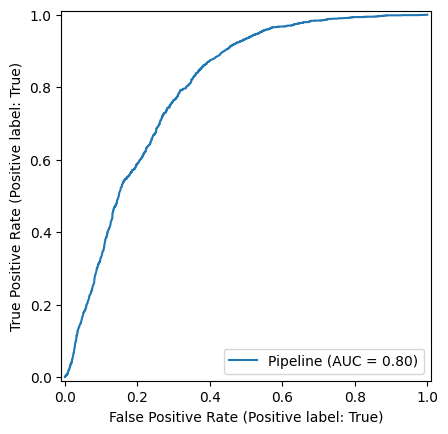

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
roc = RocCurveDisplay.from_estimator(lr_model, inputFeatures, outcome)
plt.show()

In [5]:
dt_model, feature_names = train_decision_tree(inputFeatures, outcome)

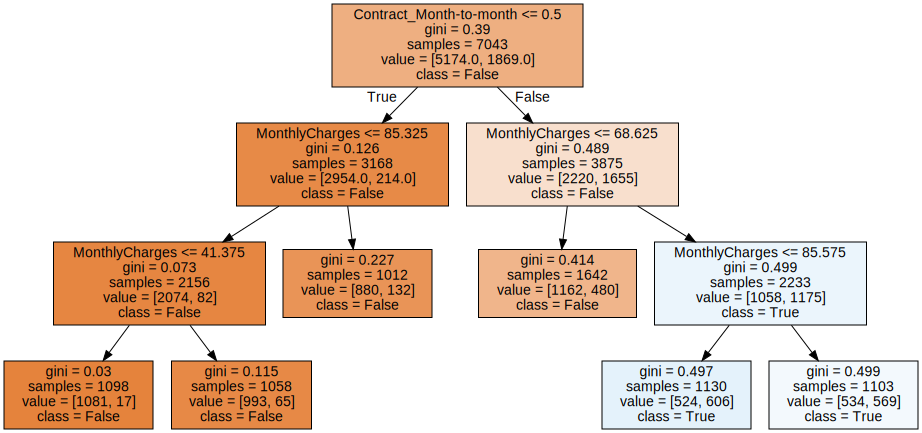

<Figure size 2500x2000 with 0 Axes>

In [6]:
import sklearn.tree as tree
import graphviz
fig = plt.figure(figsize=(25,20))
dot_data = tree.export_graphviz(dt_model.named_steps['classifier'], feature_names=feature_names, class_names=["False", "True"], filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png")
graph

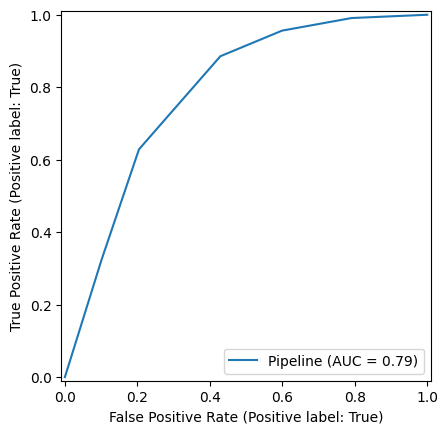

In [7]:
roc = RocCurveDisplay.from_estimator(dt_model, inputFeatures, outcome)
plt.show()